# **DSAI 585  Generative AI**  
## **Assignment 1 (15 pts)**  
### **Deadline: 17/12/2025**


## Full Name: Taha Yiğit Erdoğan

## Student ID: 2024776024


Please complete all required parts of this notebook and submit **a single .ipynb file** as your final assignment.  
Make sure all cells run without errors and all requested outputs are visible in the submitted notebook.


##  **Overview**

In this assignment, you will implement and compare three major classes of deep generative models:

- **Variational Autoencoders (VAE)**
- **Generative Adversarial Networks**
- **Normalizing Flows**

All models will be trained on the **CelebA** dataset.  
You will:

- Build and train each model from scratch  
- Generate samples and visualize the results  
- Perform latent-space interpolation  
- Compute likelihood estimates  
- Compare the models in terms of:
  - sample quality  
  - smoothness of interpolation   
  - density estimation capability
  - reconstruction performance
  - training stability

### Warning: Save Your Models Frequently

Google Colab sessions can reset, disconnect, or time out unexpectedly.  
To avoid losing your trained models, **make sure to save checkpoints regularly**.


###  Optional: Mount Google Drive

If you are using Google Colab, you may mount your Drive below to avoid losing models or outputs.
Uncomment and run the cell below to mount your Drive:

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create a folder in your Google Drive where all model checkpoints and outputs for this assignment will be saved.


In [3]:
project_path = "/content/drive/MyDrive/DSAI585-Assignment1" # This path will also be used to save models later

In [12]:
os.makedirs(project_path, exist_ok=True)
print("Created:", project_path)

Created: /content/drive/MyDrive/DSAI585-Assignment1


##  **CelebA Dataset Preparation**

In this assignment, we will use the **CelebA** dataset, a large-scale face dataset containing **202,599 celebrity images**.  
Each image is cropped and resized to **32×32** for faster training of VAE, GAN, and RealNVP models.

Below, we show an example of how to download the dataset using **kagglehub**.  
If you prefer to download CelebA manually or from another source, simply update the paths accordingly so that:

- `img_dir` points to the folder containing the face images  

The following cell sets up the dataset and creates PyTorch `DataLoader`s for training, validation, and testing.


In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [5]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celeba-dataset' dataset.
Path to dataset files: /kaggle/input/celeba-dataset


In [6]:
from PIL import Image
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

#Split and transform the data
base_path = "/kaggle/input/celeba-dataset" #Root folder where CelebA is located (change if needed)
img_dir = os.path.join(base_path, "img_align_celeba", "img_align_celeba")
split_file = os.path.join(base_path, "list_eval_partition.csv")

splits = pd.read_csv(split_file)
splits.columns = ["image_id", "split"]

class CelebADataset(Dataset):
    def __init__(self, img_dir, img_list, transform=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_imgs = splits[splits["split"] == 0]["image_id"].tolist()
val_imgs   = splits[splits["split"] == 1]["image_id"].tolist()
test_imgs  = splits[splits["split"] == 2]["image_id"].tolist()

train_dataset = CelebADataset(img_dir, train_imgs, transform)
val_dataset   = CelebADataset(img_dir, val_imgs, transform)
test_dataset  = CelebADataset(img_dir, test_imgs, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")


Train images: 162770
Validation images: 19867
Test images: 19962


##  **Q1. Variational Autoencoders (3 pts)**

We begin by defining the key hyperparameters for our VAE model:

- `CHANNELS`: number of image channels (CelebA is RGB → 3)
- `BATCH_SIZE`: training batch size  
- `LATENT_DIM`: dimensionality of the latent space \( z \)  
- `LR`: learning rate for the optimizer  
- `VAE_EPOCHS`: number of training epochs for the VAE  

You may change these values if you want.


In [7]:
CHANNELS   = 3
LATENT_DIM = 64
LR         = 2e-4
VAE_EPOCHS = 10

### Import Required Libraries

This cell loads all required Python libraries and PyTorch modules.

In [8]:
import os, math, itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### **a) VAE Architecture**

In this section, you will implement the main components of a Variational Autoencoder (VAE).

Your tasks:

- Complete the **Decoder** architecture  
- Implement the **Reparameterization Trick**  
- Implement the **VAE forward pass**  
- Fill in **all blank functions**, including their `__init__` methods

The **Encoder** is already provided and should not be modified.

Wherever the function bodies are left empty, you must write the required code to complete the VAE.


In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.conv1 = nn.Conv2d(CHANNELS, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        h = IMAGE_SIZE // 8
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(256*h*h, latent_dim)
        self.fc_logvar = nn.Linear(256*h*h, latent_dim)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        """
        Decoder network of the VAE.
        Takes a latent vector z and reconstructs an image of shape (C, H, W).
        """
        super().__init__()
        # Calculate the spatial size before the linear layer (h = 32 // 8 = 4)
        self.h = IMAGE_SIZE // 8

        # 1. Project latent vector z back to the flattened feature map size
        self.fc = nn.Linear(latent_dim, 256 * self.h * self.h)

        # 2. Transposed Convolutions (Upsampling)
        # These are the exact reverse of the Encoder's Conv2d layers
        # Input: (256, 4, 4) -> Output: (128, 8, 8)
        self.conv_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)

        # Input: (128, 8, 8) -> Output: (64, 16, 16)
        self.conv_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)

        # Input: (64, 16, 16) -> Output: (3, 32, 32)
        self.conv_trans3 = nn.ConvTranspose2d(64, CHANNELS, kernel_size=4, stride=2, padding=1)


    def forward(self, z):
        """
        Forward pass of the decoder.
        Maps latent vector z -> reconstructed image x_hat.
        """
        # Expand z back to the flat feature map
        x = self.fc(z)

        # Reshape to (Batch_Size, Channels, Height, Width) -> (B, 256, 4, 4)
        x = x.view(-1, 256, self.h, self.h)

        # Upsample blocks
        x = F.relu(self.conv_trans1(x))
        x = F.relu(self.conv_trans2(x))

        # Final layer uses Sigmoid because images are normalized to [0, 1] by ToTensor()
        x = torch.sigmoid(self.conv_trans3(x))
        return x


def reparameterize(mu, logvar):
    """
    Reparameterization trick.
    Converts (mu, logvar) into a sampled latent vector z.
    Formula: z = mu + epsilon * sigma
    """
    # 1. Calculate standard deviation (sigma)
    # We predict log(variance) for numerical stability.
    # sigma = exp(0.5 * log_variance)
    std = torch.exp(0.5 * logvar)

    # 2. Sample epsilon from a standard normal distribution (random noise)
    # randn_like ensures epsilon has the same shape and device (CPU/GPU) as std
    eps = torch.randn_like(std)

    # 3. Apply the shift (mu) and scale (std)
    z = mu + eps * std
    return z


class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        """
        Initializes the VAE model.
        Should construct an Encoder and Decoder using the given latent dimension.
        """
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        """
        Forward pass of the VAE.
        Should return: reconstructed image, mu, logvar, and sampled z.
        """
        # 1. Encode image to latent distribution parameters
        mu, logvar = self.encoder(x)

        # 2. Sample z using the reparameterization trick
        # Note: During training we sample; during inference (eval) we typically just use mu.
        # However, for training forward pass, we always use the trick.
        z = reparameterize(mu, logvar)

        # 3. Decode z back to image
        x_recon = self.decoder(z)

        return x_recon, mu, logvar, z


vae = VAE().to(device)
param_count = sum(p.numel() for p in vae.parameters())
print(f"Total VAE Parameters: {param_count:,}")

Total VAE Parameters: 2,108,163


### **b) Training the VAE**

In this section, you will train your VAE model.  
Only the loss function and the contents of the training loop need to be filled in.

You should:

- use the provided `run_epoch` function to run training and validation  
- record training and validation losses  
- monitor the printed outputs  
- save the best-performing model during training  

Complete only the indicated parts; the rest of the code should remain unchanged.


In [26]:
# --- Pre-requisite: Define path for saving ---
project_path = "."  # Saves to current directory in Colab
# ---------------------------------------------

optimizer = torch.optim.Adam(vae.parameters(), lr=LR)
# reduction='sum' means we add up the error of every single pixel in the batch
bce = nn.BCELoss(reduction='sum')

def loss_fn(x_hat, x, mu, logvar):
    """
    VAE loss function.
    Computes Reconstruction loss + KL divergence.
    """
    # 1. Reconstruction Loss (How bad is the image?)
    # x_hat is the output (sigmoid), x is the real image
    recon_loss = bce(x_hat, x)

    # 2. KL Divergence (How bad is the distribution?)
    # This forces the distribution to look like a standard normal (bell curve)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # 3. Total Loss
    total_loss = recon_loss + kl_loss

    return total_loss, recon_loss, kl_loss

def run_epoch(loader, train=True):
    vae.train(train)
    total = total_r = total_kl = n = 0
    for xb in loader:
        xb = xb.to(device)
        if train: optimizer.zero_grad()
        xh, mu, logvar, _ = vae(xb)
        loss, r, k = loss_fn(xh, xb, mu, logvar)
        if train:
            loss.backward()
            optimizer.step()
        bs = xb.size(0)
        total += loss.item() # loss is already summed over batch
        total_r += r.item()
        total_kl += k.item()
        n += bs
    # Return average loss per sample (Total / Number of samples)
    return total/n, total_r/n, total_kl/n

In [27]:
checkpoint_path = os.path.join(project_path, "vae_checkpoint.pt")
best_val = float('inf')
train_losses = []
val_losses = []

print("Starting VAE Training...")
print(f"{'Epoch':<6} | {'Train Loss':<12} | {'Val Loss':<12} | {'Time':<10}")
print("-" * 50)

import time

for epoch in range(1, VAE_EPOCHS + 1):
    start_time = time.time()

    # 1. Run Training
    t_loss, t_r, t_k = run_epoch(train_loader, train=True)
    train_losses.append(t_loss)

    # 2. Run Validation (No gradient calculation needed, faster)
    with torch.no_grad():
        v_loss, v_r, v_k = run_epoch(val_loader, train=False)
    val_losses.append(v_loss)

    # 3. Save Best Model
    # If the current validation loss is lower than our best so far, save it!
    if v_loss < best_val:
        best_val = v_loss
        torch.save(vae.state_dict(), checkpoint_path)
        saved_msg = " [Saved]"
    else:
        saved_msg = ""

    # 4. Print Progress
    duration = time.time() - start_time
    print(f"{epoch:<6} | {t_loss:<12.2f} | {v_loss:<12.2f} | {duration:<5.1f}s{saved_msg}")

print("\nTraining Complete.")

Starting VAE Training...
Epoch  | Train Loss   | Val Loss     | Time      
--------------------------------------------------
1      | 1704.87      | 1658.38      | 449.8s [Saved]
2      | 1645.43      | 1648.41      | 77.0 s [Saved]
3      | 1639.02      | 1643.73      | 79.0 s [Saved]
4      | 1635.88      | 1641.49      | 74.6 s [Saved]
5      | 1634.01      | 1640.30      | 75.1 s [Saved]
6      | 1632.65      | 1638.60      | 76.2 s [Saved]
7      | 1631.67      | 1637.87      | 79.0 s [Saved]
8      | 1630.88      | 1636.85      | 78.8 s [Saved]
9      | 1630.24      | 1636.59      | 79.7 s [Saved]
10     | 1629.66      | 1635.87      | 73.4 s [Saved]

Training Complete.


### **c) Plot Training and Validation Loss**

After training your VAE, plot the **training** and **validation** losses across epochs.  
Use the recorded `train_losses` and `val_losses` lists to visualize how the model learns over time.


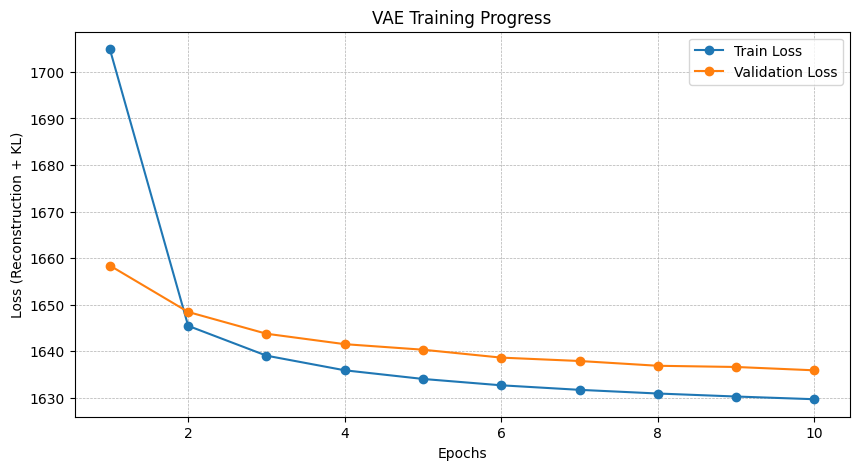

In [29]:
# c)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')

plt.title("VAE Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Loss (Reconstruction + KL)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot (optional, good practice for reports)
plt.savefig(os.path.join(project_path, "vae_loss_curve.png"))
plt.show()

## **Q2. Generative Adversarial Networks (GAN) (4 pts)**

In this section, you will implement and train a **DCGAN** model using the same CelebA dataset.

The global variables defined earlier in Q1 (such as  `CHANNELS`, `BATCH_SIZE`, `LATENT_DIM`, and `LR`)  
will also be used here, so we do **not** redefine them in this part.

Below, we specify only the additional GAN-specific hyperparameters.
You may change them as you wish.


In [10]:
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
GAN_EPOCHS = 20

### **a) DCGAN Architecture**

In this part, you will implement the **Discriminator** and **Generator** architectures for a DCGAN model.

Both modules are provided with empty bodies.  
You may design them by following the same convolutional structure used in the VAE:

- The **Discriminator** may follow the pattern of the VAE **Encoder**  
  (stacked Conv → LeakyReLU → Conv → LeakyReLU … → FC).

- The **Generator** may follow the pattern of the VAE **Decoder**  
  (Linear → reshape → ConvTranspose → ReLU / BatchNorm → … → Sigmoid).

You should also complete the **`train_step` method** inside the DCGAN class.  
This function performs one full GAN update:
- update the discriminator on both real and fake images  
- update the generator so that it fools the discriminator  
- compute and return both D and G losses

Fill in the missing parts of the classes to complete the DCGAN architecture.


In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=CHANNELS, latent_dim=LATENT_DIM):
        """
        Discriminator network for DCGAN.
        Should map an input image (C,H,W) to a single real/fake score.
        """
        super().__init__()

        # 1. Input Layer: (3, 32, 32) -> (64, 16, 16)
        # Note: Standard DCGAN does NOT use BatchNorm in the very first layer.
        self.layer1 = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 2. Hidden Layer 1: (64, 16, 16) -> (128, 8, 8)
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 3. Hidden Layer 2: (128, 8, 8) -> (256, 4, 4)
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 4. Output Layer: Flatten -> Linear -> Logit
        self.flatten = nn.Flatten()
        # The feature map size is 4x4 with 256 channels
        self.fc = nn.Linear(256 * 4 * 4, 1)

    def forward(self, x):
        """
        Forward pass of the discriminator.
        Should output a (batch_size, 1) tensor of logits.
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)

        # Output is raw score (logits), not probability
        logits = self.fc(x)
        return logits

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, img_channels=CHANNELS):
        """
        Generator network for DCGAN.
        Maps latent vector z to an image (C,H,W).
        """
        super().__init__()

        # We start by matching the Discriminator's deepest feature map size (4x4)
        self.init_size = 4
        # The Discriminator ended with 256 channels, so we start with 256
        self.feature_map_size = 256 * self.init_size * self.init_size

        # 1. Linear Projection: Expand the latent vector into a large feature vector
        self.fc = nn.Linear(latent_dim, self.feature_map_size)
        self.bn1 = nn.BatchNorm1d(self.feature_map_size) # Stabilizes the linear output

        # 2. Upsampling Block 1: (256, 4, 4) -> (128, 8, 8)
        self.conv_trans1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # 3. Upsampling Block 2: (128, 8, 8) -> (64, 16, 16)
        self.conv_trans2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        # 4. Output Block: (64, 16, 16) -> (3, 32, 32)
        # Note: No BatchNorm in the final layer! It would ruin the color distribution.
        self.conv_trans3 = nn.Sequential(
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # Squashes output to [0, 1] to match the dataset
        )

    def forward(self, z):
        """
        Forward pass of the generator.
        Output: Image tensor in range [0,1].
        """
        # 1. Project and Reshape
        out = self.fc(z)
        out = self.bn1(out)
        out = F.relu(out)

        # Reshape the flat vector into a 3D feature cube (Batch, 256, 4, 4)
        out = out.view(-1, 256, self.init_size, self.init_size)

        # 2. Upsample
        out = self.conv_trans1(out)
        out = self.conv_trans2(out)

        # 3. Final Image
        img = self.conv_trans3(out)
        return img

In [13]:
class DCGAN:
    def __init__(self, discriminator, generator, latent_dim=LATENT_DIM, device=device):
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.device = device

        self.d_optimizer = None
        self.g_optimizer = None

        # BCE loss on raw logits (BCEWithLogitsLoss is more stable than BCELoss + Sigmoid)
        self.criterion = nn.BCEWithLogitsLoss()

        self.reset_metrics()

    def compile(self, d_optimizer, g_optimizer):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def reset_metrics(self):
        """Reset running averages."""
        self.d_loss = 0.0
        self.g_loss = 0.0
        self.count = 0

    def train_step(self, real_images):
        """
        Performs one training step of DCGAN.
        """
        batch_size = real_images.size(0)
        # Move real images to GPU
        real_images = real_images.to(self.device)

        # ====================================
        #  1. Train the Discriminator
        # ====================================
        self.d_optimizer.zero_grad()

        # -- A. Train on Real Images --
        real_labels = torch.ones(batch_size, 1, device=self.device)
        real_logits = self.discriminator(real_images)
        d_loss_real = self.criterion(real_logits, real_labels)

        # -- B. Train on Fake Images --
        fake_labels = torch.zeros(batch_size, 1, device=self.device)

        # Generate noise and fake images
        z = torch.randn(batch_size, self.latent_dim, device=self.device)
        fake_images = self.generator(z)

        # IMPT: Detach to stop gradients flowing to Generator here
        fake_logits = self.discriminator(fake_images.detach())
        d_loss_fake = self.criterion(fake_logits, fake_labels)

        # -- C. Update Discriminator --
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        # ====================================
        #  2. Train the Generator
        # ====================================
        self.g_optimizer.zero_grad()

        # Generator wants D to think images are REAL (label 1)
        # We use the same fake_images (graph is preserved)
        output = self.discriminator(fake_images)
        g_loss = self.criterion(output, real_labels)

        g_loss.backward()
        self.g_optimizer.step()

        # ====================================
        #  3. Record Metrics
        # ====================================
        self.d_loss += d_loss.item()
        self.g_loss += g_loss.item()
        self.count += 1

        return {"d_loss": d_loss.item(), "g_loss": g_loss.item()}

In [14]:
#Initialize Discriminator and Generator
discriminator = Discriminator(img_channels=CHANNELS, latent_dim=LATENT_DIM).to(device)
generator = Generator(latent_dim=LATENT_DIM, img_channels=CHANNELS).to(device)

print("Discriminator params:", sum(p.numel() for p in discriminator.parameters()))
print("Generator params:", sum(p.numel() for p in generator.parameters()))

#Create DCGAN training object
dcgan = DCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=LATENT_DIM,
    device=device
)

#Optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr=LR,
    betas=(ADAM_BETA_1, ADAM_BETA_2)
)

g_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr=LR,
    betas=(ADAM_BETA_1, ADAM_BETA_2)
)

dcgan.compile(d_optimizer, g_optimizer)

print("DCGAN is initialized and ready to train.")

Discriminator params: 663745
Generator params: 933443
DCGAN is initialized and ready to train.


### **b) Training the DCGAN**

Use the cell below to train your DCGAN model.  
It calls the `train_step` function that you implemented and keeps track of the
**discriminator** and **generator** losses across epochs.  

You do **not** need to modify this cell.

After training finishes, use the recorded `d_losses` and `g_losses`
lists to create a plot showing how both losses evolve over time.


In [49]:
#checkpoint path
gan_ckpt_path = os.path.join(project_path, "dcgan_checkpoint.pt")

#Lists to store losses per epoch
d_losses = []
g_losses = []

best_g_loss = float("inf")

for epoch in range(1, GAN_EPOCHS + 1):
    dcgan.reset_metrics()

    for step, imgs in enumerate(train_loader):
        stats = dcgan.train_step(imgs)

        if step % 50 == 0:
            print(
                f"[Epoch {epoch:03d} | Step {step:04d}] "
                f"D: {stats['d_loss']:.4f} | G: {stats['g_loss']:.4f}"
            )

    #Take the running averages from dcgan
    d_epoch_loss = stats["d_loss"]
    g_epoch_loss = stats["g_loss"]

    d_losses.append(d_epoch_loss)
    g_losses.append(g_epoch_loss)

    print(
        f"Epoch {epoch:03d} finished "
        f"=> D loss: {d_epoch_loss:.4f} | G loss: {g_epoch_loss:.4f}"
    )

    #Save best model based on generator loss
    if g_epoch_loss < best_g_loss:
        best_g_loss = g_epoch_loss
        torch.save(
            {
                "epoch": epoch,
                "discriminator_state_dict": dcgan.discriminator.state_dict(),
                "generator_state_dict": dcgan.generator.state_dict(),
                "d_optimizer_state_dict": dcgan.d_optimizer.state_dict(),
                "g_optimizer_state_dict": dcgan.g_optimizer.state_dict(),
                "d_losses": d_losses,
                "g_losses": g_losses,
            },
            gan_ckpt_path,
        )
        print(f" → Saved new BEST DCGAN model at epoch {epoch} to:\n    {gan_ckpt_path}")

print("DCGAN training completed!")


[Epoch 001 | Step 0000] D: 1.3629 | G: 1.8346
[Epoch 001 | Step 0050] D: 0.0789 | G: 6.6590
[Epoch 001 | Step 0100] D: 0.2928 | G: 2.7017
[Epoch 001 | Step 0150] D: 0.6199 | G: 2.4137
[Epoch 001 | Step 0200] D: 0.8098 | G: 3.0389
[Epoch 001 | Step 0250] D: 0.9685 | G: 3.0324
[Epoch 001 | Step 0300] D: 0.7960 | G: 1.3665
[Epoch 001 | Step 0350] D: 0.6822 | G: 1.8324
[Epoch 001 | Step 0400] D: 0.6295 | G: 2.1912
[Epoch 001 | Step 0450] D: 0.9269 | G: 2.2181
[Epoch 001 | Step 0500] D: 0.5581 | G: 2.6562
[Epoch 001 | Step 0550] D: 1.0498 | G: 1.3441
[Epoch 001 | Step 0600] D: 1.0519 | G: 1.3139
[Epoch 001 | Step 0650] D: 0.7563 | G: 1.6677
[Epoch 001 | Step 0700] D: 0.8609 | G: 2.6288
[Epoch 001 | Step 0750] D: 1.0632 | G: 0.7533
[Epoch 001 | Step 0800] D: 0.7831 | G: 1.8461
[Epoch 001 | Step 0850] D: 0.6796 | G: 1.6593
[Epoch 001 | Step 0900] D: 0.6873 | G: 1.4950
[Epoch 001 | Step 0950] D: 0.8074 | G: 2.4833
[Epoch 001 | Step 1000] D: 0.6106 | G: 2.4827
[Epoch 001 | Step 1050] D: 0.9410 

In [50]:
# Save the final (Epoch 20) model manually
#final_path = os.path.join(project_path, "dcgan_final.pt")

#torch.save(dcgan.generator.state_dict(), final_path)

#print(f"✅ Successfully saved the Final Epoch 20 model to:\n   {final_path}")

✅ Successfully saved the Final Epoch 20 model to:
   ./dcgan_final.pt


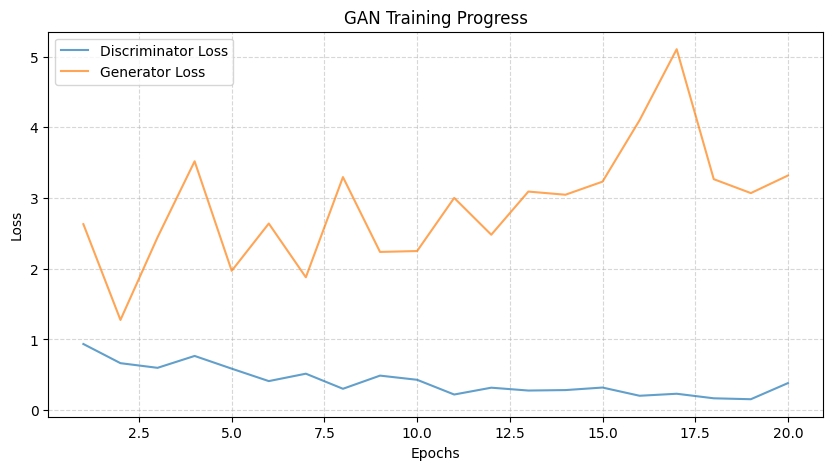

In [51]:
# Plot Discriminator and Generator losses vs epoch
# Use the recorded d_losses and g_losses lists
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(d_losses) + 1), d_losses, label='Discriminator Loss', alpha=0.7)
plt.plot(range(1, len(g_losses) + 1), g_losses, label='Generator Loss', alpha=0.7)

plt.title("GAN Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Save plot
plt.savefig(os.path.join(project_path, "gan_loss_curve.png"))
plt.show()

## **Q3. Normalizing Flows (4 pts)**

In this section, you will implement and train a **RealNVP/Glow-style normalizing flow** model using the same CelebA dataset.

The global variables defined earlier (such as `CHANNELS`, `LATENT_DIM`, and `LR`)  
will also be used here, so we do **not** redefine them in this part.

Below, we specify only the additional flow-specific hyperparameters.  
You may change them as you wish.

In [15]:
H = IMAGE_SIZE
W = IMAGE_SIZE

COUPLING_LAYERS = 32

#Training epochs
FLOW_EPOCHS = 10

#L2 regularization
WEIGHT_DECAY = 1e-5

### **a) RealNVP Architecture**

In this part, you will implement the core components of a **RealNVP/Glow-style normalizing flow**.

Several helper functions are already provided (e.g., `squeeze2x2`, `unsqueeze2x2`, `ActNorm`, `Invertible1x1Conv`).  
Your task is to complete the following modules:

- **`STNetConv`** – predicts the scale and translation tensors `(s, t)` used in affine coupling.  
- **`ConvCouplingLayer`** – applies the affine coupling transform using a binary mask and the `STNetConv` network.  
- **`FlowStep`** – one flow block combining: `ActNorm → Invertible1x1Conv → Affine Coupling`.  
- **`RealNVPConv`** – implements the full forward pass (`f`), inverse pass (`f_inv`), and likelihood computation (`log_prob`, `nll`).

You may keep the structure as provided, but you are also free to add or remove components inside the flow (such as **ActNorm**, **Invertible1x1Conv**, or **squeeze2x2**), or adjust the internal functions, if you believe it improves stability or performance.

For reference, you can read the original papers:

- [Density Estimation Using Real NVP (RealNVP)](https://doi.org/10.48550/arXiv.1605.08803)  
- [Glow: Generative Flow with Invertible 1×1 Convolutions (Glow)](https://doi.org/10.48550/arXiv.1807.03039)

In [16]:
def squeeze2x2(x):
    B, C, H, W = x.shape
    assert H % 2 == 0 and W % 2 == 0
    x = x.view(B, C, H//2, 2, W//2, 2)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    x = x.view(B, 4*C, H//2, W//2)
    return x

def unsqueeze2x2(x):
    B, C, H, W = x.shape
    assert C % 4 == 0
    x = x.view(B, C//4, 2, 2, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    x = x.view(B, C//4, H*2, W*2)
    return x


In [17]:
class ActNorm(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.log_scale = nn.Parameter(torch.zeros(1, num_channels, 1, 1))

        # --- UPGRADE: Save the initialization state in the file! ---
        self.register_buffer('initialized', torch.tensor(0, dtype=torch.uint8))

    def initialize(self, x):
        with torch.no_grad():
            mean = x.mean(dim=[0, 2, 3], keepdim=True)
            std  = x.std(dim=[0, 2, 3], keepdim=True)
            self.bias.data = -mean
            self.log_scale.data = torch.log(1.0 / (std + 1e-6))
        # Mark as initialized (1 = True)
        self.initialized.fill_(1)

    def forward(self, x):
        # Check buffer (item() gets the value 0 or 1)
        if self.initialized.item() == 0:
            self.initialize(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        B, _, H, W = x.shape
        log_det = self.log_scale.sum() * H * W
        log_det = log_det.expand(B)
        return y, log_det

    def inverse(self, y):
        if self.initialized.item() == 0:
            self.initialize(y)
        x = y * torch.exp(-self.log_scale) - self.bias
        return x

class Invertible1x1Conv(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        W = torch.linalg.qr(torch.randn(num_channels, num_channels))[0]
        self.weight = nn.Parameter(W)

    def forward(self, x):
        B, C, H, W = x.shape
        W_mat = self.weight.view(C, C)
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, C)
        x_flat = x_flat @ W_mat.T
        x = x_flat.view(B, H, W, C).permute(0, 3, 1, 2)
        log_det_W = torch.slogdet(W_mat)[1]
        log_det = log_det_W * H * W
        log_det = log_det.expand(B)
        return x, log_det

    def inverse(self, x):
        B, C, H, W = x.shape
        W_mat = self.weight.view(C, C)
        W_inv = torch.inverse(W_mat)
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, C)
        x_flat = x_flat @ W_inv.T
        x = x_flat.view(B, H, W, C).permute(0, 3, 1, 2)
        return x

In [18]:
class STNetConv(nn.Module):
    def __init__(self, in_channels, hidden=LATENT_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, 2 * in_channels, kernel_size=3, padding=1)
        )
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()

    def forward(self, x):
        st = self.net(x)
        s, t = torch.chunk(st, 2, dim=1)
        s = torch.tanh(s)
        return s, t

class ConvCouplingLayer(nn.Module):
    def __init__(self, mask, num_channels, hidden=LATENT_DIM):
        super().__init__()
        self.register_buffer("mask", mask)
        self.st = STNetConv(num_channels, hidden=hidden)

    def forward(self, x):
        x_masked = x * self.mask
        s, t = self.st(x_masked)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        y = x * torch.exp(s) + t
        # CORRECTED SUMMING METHOD
        log_det = s.sum(dim=[1, 2, 3])
        return y, log_det

    def inverse(self, y):
        y_masked = y * self.mask
        s, t = self.st(y_masked)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        x = (y - t) * torch.exp(-s)
        return x

class FlowStep(nn.Module):
    def __init__(self, num_channels, mask, hidden=LATENT_DIM):
        super().__init__()
        self.actnorm = ActNorm(num_channels)
        self.conv1x1 = Invertible1x1Conv(num_channels)
        self.coupling = ConvCouplingLayer(mask, num_channels, hidden=hidden)

    def forward(self, x):
        x, ld1 = self.actnorm(x)
        x, ld2 = self.conv1x1(x)
        x, ld3 = self.coupling(x)
        return x, ld1 + ld2 + ld3

    def inverse(self, x):
        x = self.coupling.inverse(x)
        x = self.conv1x1.inverse(x)
        x = self.actnorm.inverse(x)
        return x

In [19]:
class RealNVPConv(nn.Module):
    def __init__(self, h=IMAGE_SIZE, w=IMAGE_SIZE, coupling_layers=COUPLING_LAYERS, hidden=LATENT_DIM):
        super().__init__()
        self.h = h
        self.w = w
        self.c = CHANNELS
        self.inner_h = h // 2
        self.inner_w = w // 2
        self.inner_c = CHANNELS * 4
        masks = []
        for i in range(coupling_layers):
            if i % 2 == 0:
                invert = ((i // 2) % 2 == 1)
                mask = self.create_checkerboard_mask(self.inner_c, self.inner_h, self.inner_w, invert=invert)
            else:
                invert = ((i // 2) % 2 == 1)
                mask = self.create_channel_mask(self.inner_c, invert=invert)
            masks.append(mask)
        self.steps = nn.ModuleList([FlowStep(self.inner_c, mask, hidden=hidden) for mask in masks])

    @staticmethod
    def create_checkerboard_mask(channels, h, w, invert=False):
        base = (np.indices((h, w)).sum(axis=0) % 2).astype("float32")
        if invert: base = 1.0 - base
        mask = torch.tensor(base).view(1, 1, h, w)
        mask = mask.repeat(1, channels, 1, 1)
        return mask

    @staticmethod
    def create_channel_mask(channels, invert=False):
        mask = torch.zeros(channels, dtype=torch.float32)
        mask[: channels // 2] = 1.0
        if invert: mask = 1.0 - mask
        mask = mask.view(1, channels, 1, 1)
        return mask

    def f(self, x_c):
        z = squeeze2x2(x_c)
        log_det_sum = torch.zeros(z.size(0), device=z.device)
        for step in self.steps:
            z, ld = step(z)
            log_det_sum += ld
        return z, log_det_sum

    def f_inv(self, z):
        for step in reversed(self.steps):
            z = step.inverse(z)
        x_c = unsqueeze2x2(z)
        return x_c

    def log_prob(self, x):
        x_c = x - 0.5
        z, log_det_J = self.f(x_c)
        log_p_z = -0.5 * (z.pow(2) + math.log(2 * math.pi))
        log_p_z = log_p_z.sum(dim=[1, 2, 3])
        return log_p_z + log_det_J

    def nll(self, x):
        return -self.log_prob(x).mean()

### **b) Training the RealNVP Model**

Use the cells below to train your RealNVP/Glow-style flow model.  
They call the `nll` method you implemented and keep track of the **negative log-likelihood (NLL)** over epochs in the list `flow_losses`.

You do **not** need to modify these cells.

After training finishes, use the recorded `flow_losses` list to create a plot showing  
how the NLL evolves over time (e.g., NLL vs. epoch).


In [62]:
# Use a new filename so we don't mix up with old files
flow_ckpt_path = os.path.join(project_path, "realnvp_clean_v2.pt")

print("Initializing FRESH RealNVP model...")
flow = RealNVPConv(
    h=IMAGE_SIZE,
    w=IMAGE_SIZE,
    coupling_layers=COUPLING_LAYERS,
    hidden=LATENT_DIM
).to(device)

optimizer = torch.optim.Adam(
    flow.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

flow_losses = []
best_nll = float("inf")

Initializing FRESH RealNVP model...


In [63]:
def train_realnvp(epochs=FLOW_EPOCHS, log_every=1):
    global best_nll
    print(f"Starting training for {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        flow.train()
        epoch_losses = []

        for imgs in train_loader:
            if isinstance(imgs, (list, tuple)):
                imgs = imgs[0]
            imgs = imgs.to(device)

            loss = flow.nll(imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        mean_loss = float(np.mean(epoch_losses))
        flow_losses.append(mean_loss)

        if epoch % log_every == 0 or epoch == 1:
            print(f"[Epoch {epoch:03d}/{epochs}]  NLL: {mean_loss:.4f}")

        if mean_loss < best_nll:
            best_nll = mean_loss
            # Save the model
            torch.save(flow.state_dict(), flow_ckpt_path)
            print(f" → Saved BEST RealNVP model to {flow_ckpt_path}")

    print("RealNVP training completed.")

In [64]:
#Train RealNVP
train_realnvp()

Starting training for 10 epochs...
[Epoch 001/10]  NLL: -8291.8305
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 002/10]  NLL: -8898.2467
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 003/10]  NLL: -9077.7564
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 004/10]  NLL: -9186.0211
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 005/10]  NLL: -9263.9114
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 006/10]  NLL: -9324.0255
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 007/10]  NLL: -9375.6947
 → Saved BEST RealNVP model to /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
[Epoch 008/10]  NLL: -9417.3473
 → Saved BEST RealNVP model to /content/drive/MyDri

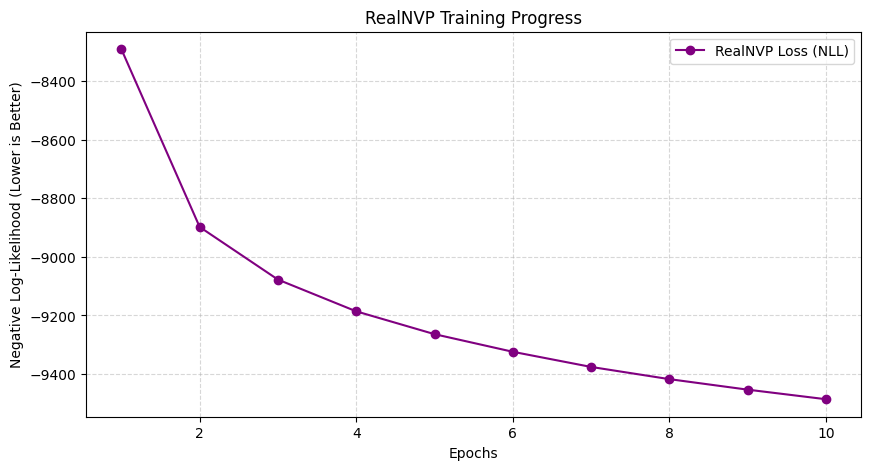

In [65]:
# Plot the RealNVP training curve using the values stored in flow_losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(flow_losses) + 1), flow_losses, label='RealNVP Loss (NLL)', marker='o', color='purple')

plt.title("RealNVP Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-Likelihood (Lower is Better)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot
plt.savefig(os.path.join(project_path, "realnvp_loss_curve.png"))
plt.show()

### **c) Reconstruction Check**

Run the cells below to compute the **average reconstruction MSE** for the **last five** validation images.  
For a correct RealNVP implementation, this average MSE should be **below 1e-6**.  
Higher values indicate a problem in your `f` or `f_inv` implementation.


In [66]:
#Compute reconstruction MSE for one image
def flow_reconstruction_loss(flow, img, device):
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        x_c = img - 0.5
        z, _ = flow.f(x_c)
        recon_c = flow.f_inv(z)
        recon = torch.clamp(recon_c + 0.5, 0.0, 1.0)

        mse = ((img - recon) ** 2).mean().item()

    return mse

In [67]:
#Compute average reconstruction MSE for last 5 validation images

total_mse = 0.0

for i in range(len(val_dataset) - 5, len(val_dataset)):
    img = val_dataset[i]
    total_mse += flow_reconstruction_loss(flow, img, device)

avg_mse = total_mse / 5
print("Average MSE (last 5 validation images):", avg_mse)


Average MSE (last 5 validation images): 2.417918240626982e-10


## **Q4. Comparison of Model Performance (4 pts)**

In this section, you will compare the performance of the VAE, DCGAN, and RealNVP models. Using the results you obtained in the previous parts, briefly evaluate how these models differ in terms of generation quality, behavior, and overall performance on the CelebA dataset.


### Loading Trained Models (Optional)

If you have already trained your VAE, DCGAN, and RealNVP models, you may load the saved checkpoints using the cell below.



In [22]:
#Paths to trained models
vae_path     = os.path.join(project_path, "vae_checkpoint.pt")
dcgan_path   = os.path.join(project_path, "dcgan_checkpoint.pt")

# ADJUSTMENT: Check for the clean v2 file first, fallback to standard name
if os.path.exists(os.path.join(project_path, "realnvp_clean_v2.pt")):
    realnvp_path = os.path.join(project_path, "realnvp_clean_v2.pt")
else:
    realnvp_path = os.path.join(project_path, "realnvp_checkpoint.pt")

print("Loading models from:")
print(" VAE:", vae_path)
print(" DCGAN:", dcgan_path)
print(" RealNVP:", realnvp_path)

#Load VAE
vae = VAE(latent_dim=LATENT_DIM).to(device)
if os.path.exists(vae_path):
    vae.load_state_dict(torch.load(vae_path, map_location=device))
    vae.eval()
    print("✅ Loaded VAE")
else:
    print("❌ VAE not found")

# Load DCGAN Generator
generator = Generator(latent_dim=LATENT_DIM, img_channels=CHANNELS).to(device)
discriminator = Discriminator(img_channels=CHANNELS).to(device)

if os.path.exists(dcgan_path):
    dcgan_ckpt = torch.load(dcgan_path, map_location=device)
    generator.load_state_dict(dcgan_ckpt["generator_state_dict"])
    discriminator.load_state_dict(dcgan_ckpt["discriminator_state_dict"])
    generator.eval()
    discriminator.eval()
    print("✅ Loaded DCGAN")
else:
    print("❌ DCGAN not found")

# Load RealNVP (FIX APPLIED)
flow = RealNVPConv(
    h=IMAGE_SIZE,
    w=IMAGE_SIZE,
    coupling_layers=COUPLING_LAYERS,
    hidden=LATENT_DIM  # <--- CRITICAL FIX: Matches training (64)
).to(device)

if os.path.exists(realnvp_path):
    rnvp_ckpt = torch.load(realnvp_path, map_location=device)

    # Handle both dict-save and direct-save formats
    if isinstance(rnvp_ckpt, dict) and "model_state_dict" in rnvp_ckpt:
        flow.load_state_dict(rnvp_ckpt["model_state_dict"])
    else:
        flow.load_state_dict(rnvp_ckpt)

    flow.eval()
    print(f"✅ Loaded RealNVP from: {os.path.basename(realnvp_path)}")
else:
    print("❌ RealNVP not found")

print("\n🎉 All models loaded successfully!")

Loading models from:
 VAE: /content/drive/MyDrive/DSAI585-Assignment1/vae_checkpoint.pt
 DCGAN: /content/drive/MyDrive/DSAI585-Assignment1/dcgan_checkpoint.pt
 RealNVP: /content/drive/MyDrive/DSAI585-Assignment1/realnvp_clean_v2.pt
✅ Loaded VAE
✅ Loaded DCGAN
✅ Loaded RealNVP from: realnvp_clean_v2.pt

🎉 All models loaded successfully!


### **a) Sampling**

In this part, you will generate samples using your trained VAE, DCGAN, and RealNVP models.  
The sampling functions are provided with empty bodies for you to complete.

After implementing the sampling functions, generate images from each model and **compare their sampling performance**.  
In your comparison, briefly comment on aspects such as:

- visual quality of generated faces  
- diversity of samples  
- realism and sharpness  
- differences in artifacts produced by each model  

**Note:** RealNVP models sometimes produce poor samples when drawing directly from a standard Gaussian prior.  
If this happens, you may consider sampling from a distribution estimated from the latent codes of real images.

Use the outputs you generate to support your observations.


In [23]:
def sample_vae(model):
    """
    Generate and display samples from a trained VAE.
    """
    model.eval()  # Ensure the model is in evaluation mode

    with torch.no_grad():
        # 1. Sample latent vectors z ~ N(0, I)
        # We generate 16 samples for a nice 4x4 grid
        z = torch.randn(16, LATENT_DIM).to(device)

        # 2. Decode them using model.decoder
        samples = model.decoder(z)

        # 3. Display the generated images in a grid
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("VAE Generated Samples")
        grid = vutils.make_grid(samples, nrow=4, padding=2, normalize=False)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.show()


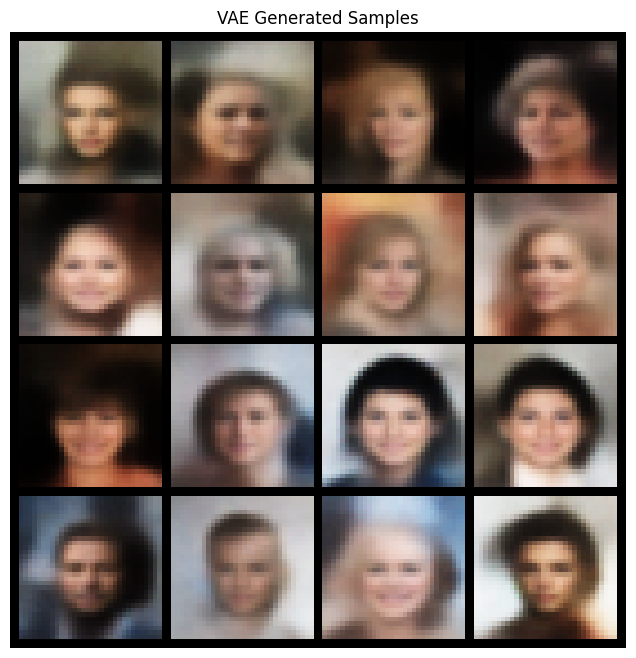

In [24]:
sample_vae(vae)

In [25]:
def sample_gan(generator):
    """
    Generate and display samples from a trained DCGAN generator.
    """
    generator.eval() # Set to evaluation mode

    with torch.no_grad():
        # 1. Sample latent vectors z ~ N(0, I)
        # We generate 16 vectors to create a 4x4 grid
        z = torch.randn(16, LATENT_DIM).to(device)

        # 2. Generate images using the generator
        # Output shape: (16, 3, 32, 32) with values in [0, 1]
        samples = generator(z)

        # 3. Display the results in a grid
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("DCGAN Generated Samples")

        # Create grid: 4 images per row
        grid = vutils.make_grid(samples, nrow=4, padding=2, normalize=False)

        # Permute from (C, H, W) to (H, W, C) for Matplotlib
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.show()

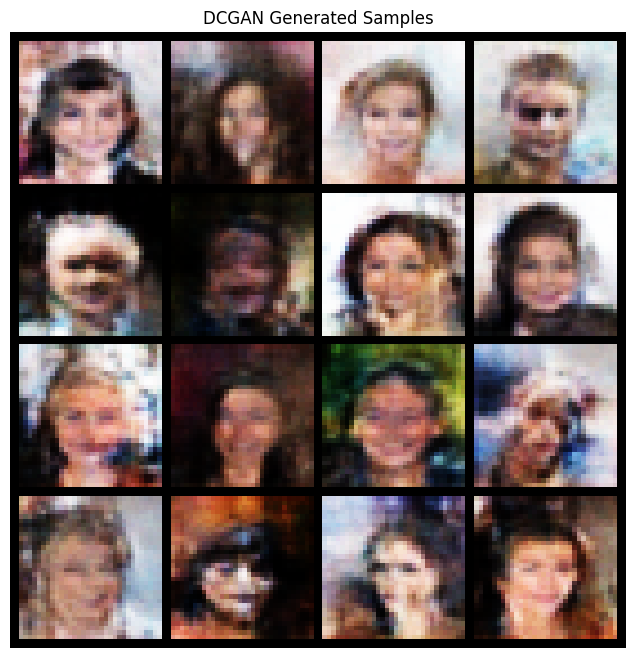

In [26]:
sample_gan(generator)

In [27]:
def sample_flow(flow):
    """
    Generate and display samples from a trained RealNVP model.
    """
    flow.eval() # Set to evaluation mode

    with torch.no_grad():
        # 1. Sample latent noise z ~ N(0, I)
        # Shape must match the Squeezed output:
        # Channels * 4 (3*4=12), Height / 2 (16), Width / 2 (16)
        c, h, w = 12, 16, 16
        z = torch.randn(16, c, h, w).to(device)

        # --- Temperature Sampling (Crucial for RealNVP) ---
        # Sampling from the full variance (1.0) often produces noisy pixels.
        # Multiplying by 0.7 forces the model to pick "safer", more realistic faces.
        z = z * 0.7

        # 2. Invert the flow (z -> x_centered)
        x_centered = flow.f_inv(z)

        # 3. Convert to [0,1] pixel space
        # We trained on (x - 0.5), so we simply add 0.5 back.
        samples = torch.clamp(x_centered + 0.5, 0.0, 1.0)

        # 4. Display the generated images
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("RealNVP Generated Samples")
        grid = vutils.make_grid(samples, nrow=4, padding=2, normalize=False)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.show()

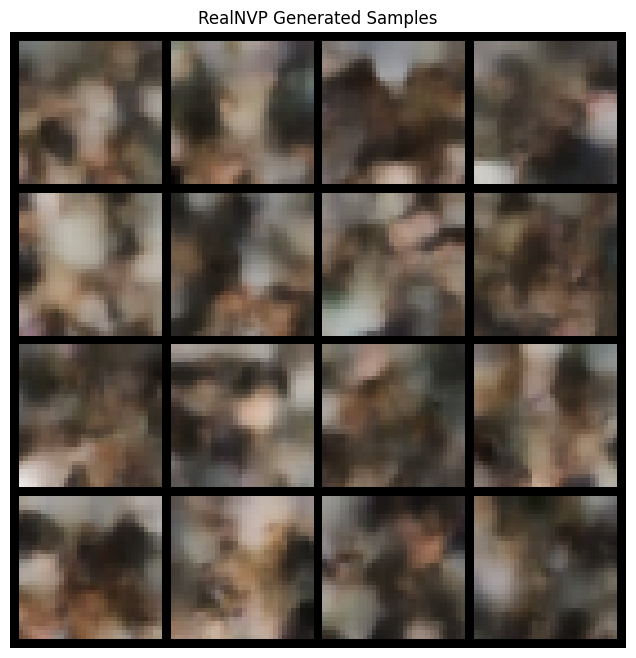

In [28]:
sample_flow(flow)

--- Diagnosing RealNVP Model ---


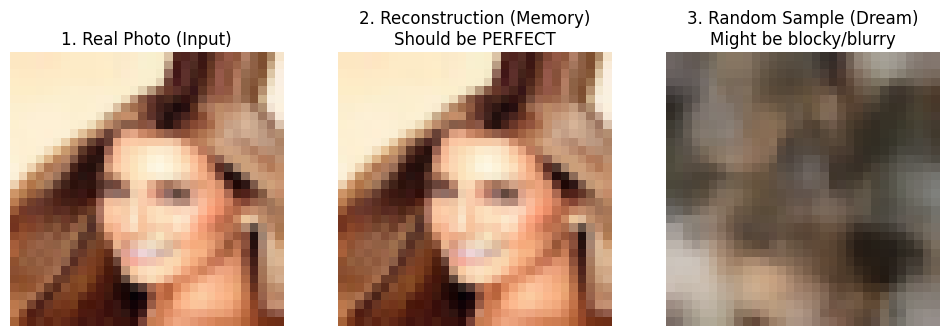

In [29]:
#EXTRA (STEP)
def check_reconstruction(model, dataset):
    model.eval()

    # 1. Get a Real Image
    real_img = dataset[0].unsqueeze(0).to(device) # Get first image

    with torch.no_grad():
        # 2. Encode it (Real -> Latent)
        # We subtract 0.5 because that's how we trained it
        z, _ = model.f(real_img - 0.5)

        # 3. Decode it immediately (Latent -> Real)
        recon_centered = model.f_inv(z)
        reconstruction = torch.clamp(recon_centered + 0.5, 0.0, 1.0)

        # 4. Generate a Random Sample (Imagination)
        c, h, w = 12, 16, 16
        z_noise = torch.randn(1, c, h, w).to(device) * 0.7
        sample_centered = model.f_inv(z_noise)
        sample = torch.clamp(sample_centered + 0.5, 0.0, 1.0)

    # 5. Show them Side-by-Side
    plt.figure(figsize=(12, 4))

    # Plot Real
    plt.subplot(1, 3, 1)
    plt.title("1. Real Photo (Input)")
    plt.imshow(real_img[0].permute(1, 2, 0).cpu())
    plt.axis('off')

    # Plot Reconstruction
    plt.subplot(1, 3, 2)
    plt.title("2. Reconstruction (Memory)\nShould be PERFECT")
    plt.imshow(reconstruction[0].permute(1, 2, 0).cpu())
    plt.axis('off')

    # Plot Random Sample
    plt.subplot(1, 3, 3)
    plt.title("3. Random Sample (Dream)\nMight be blocky/blurry")
    plt.imshow(sample[0].permute(1, 2, 0).cpu())
    plt.axis('off')

    plt.show()

# Run the test
print("--- Diagnosing RealNVP Model ---")
check_reconstruction(flow, train_dataset)

The comparison of the generated samples shows distinct differences in quality across the three models. The VAE produces the most stable results; the faces are structurally correct and diverse, but they appear significantly blurry and lack fine details. In contrast, the DCGAN generates images with much higher sharpness and contrast, making features clearer, although some samples exhibit visual noise and unrealistic color artifacts. Finally, the RealNVP model demonstrates good global structure by capturing general face shapes, but it suffers from severe blocky artifacts. These pixelated patterns appear because the model processes images in small sections and requires more training to learn smooth transitions between them.

### **b) Interpolation**

In this part, you will implement interpolation between two selected CelebA test images using the latent spaces of your models.  
You will fill in the following functions:

- **`interpolate_vae(vae, img0, img1)`**  
  Performs interpolation in the **VAE latent space** and visualizes the morphing sequence.

- **`invert_gan_image(generator, img)`**  
  Finds a latent vector **z** such that the GAN generator reconstructs the given image as closely as possible.

- **`interpolate_gan(generator, z0, z1)`**  
  Interpolates between two latent vectors **z0** and **z1** and visualizes the generated intermediate images.

- **`interpolate_realnvp(flow, img0, img1)`**  
  Performs interpolation in the **RealNVP latent space** by encoding both images, interpolating between their latent codes, and decoding them back to images.

After implementing these functions, compare the interpolation behavior of the different models.  
Comment on how smooth and realistic the transitions look, and how well each model preserves identity and structure during interpolation.


Selected image shapes: torch.Size([3, 32, 32]) torch.Size([3, 32, 32])


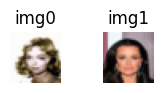

In [30]:
img0 = test_dataset[-1]
img1 = test_dataset[-2]

print("Selected image shapes:", img0.shape, img1.shape)

fig = plt.figure(figsize=(2, 1))

ax = fig.add_subplot(1, 2, 1)
ax.axis("off")
ax.set_title("img0")
ax.imshow(img0.permute(1, 2, 0).clamp(0, 1))

ax = fig.add_subplot(1, 2, 2)
ax.axis("off")
ax.set_title("img1")
ax.imshow(img1.permute(1, 2, 0).clamp(0, 1))

plt.tight_layout()
plt.show()


In [31]:
@torch.no_grad()
def interpolate_vae(vae, img0, img1, steps=10):
    """
    Interpolate between two images in the VAE latent space.
    """
    vae.eval()

    # 1. Prepare images (Add batch dimension: (1, C, H, W))
    img0 = img0.unsqueeze(0).to(device)
    img1 = img1.unsqueeze(0).to(device)

    # 2. Encode to Latent Space
    # We use mu (the mean) for interpolation as it represents the center of the distribution
    mu0, _ = vae.encoder(img0)
    mu1, _ = vae.encoder(img1)

    # 3. Create interpolation vectors
    # Shape: (steps, latent_dim)
    ratios = np.linspace(0, 1, steps)
    latents = []

    for alpha in ratios:
        z = mu0 * (1 - alpha) + mu1 * alpha
        latents.append(z)

    latents = torch.cat(latents, dim=0) # Stack into (steps, latent_dim)

    # 4. Decode
    generated_imgs = vae.decoder(latents)

    # 5. Plot
    plt.figure(figsize=(15, 4))
    grid = vutils.make_grid(generated_imgs, nrow=steps, padding=2, normalize=False)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("VAE Interpolation")
    plt.show()

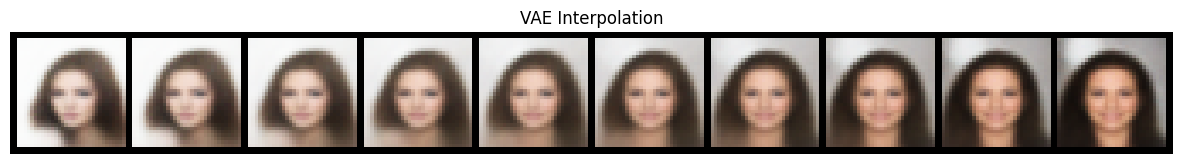

In [32]:
interpolate_vae(vae, img0, img1)

In [33]:
def invert_gan_image(generator, img, z_dim=LATENT_DIM, steps=500, lr=1e-2):
    """
    Find a latent code z such that G(z) ≈ img by gradient descent on z.
    """
    generator.eval() # Freeze generator layers (batchnorm stats, etc)
    target_img = img.unsqueeze(0).to(device)

    # 1. Initialize z randomly (requires_grad=True so we can optimize it)
    z_opt = torch.randn(1, z_dim, device=device, requires_grad=True)

    # 2. Setup Optimizer just for this z
    optimizer = torch.optim.Adam([z_opt], lr=lr)
    loss_fn = torch.nn.MSELoss()

    # 3. Optimization Loop
    # We are not training the network! We are training 'z' to match this one image.
    for i in range(steps):
        optimizer.zero_grad()

        generated = generator(z_opt)
        loss = loss_fn(generated, target_img)

        loss.backward()
        optimizer.step()

    return z_opt.detach() # Return the optimized vector without gradients

In [34]:
print("Inverting GAN (Running optimization on z)...")
z0 = invert_gan_image(generator, img0, z_dim=LATENT_DIM, steps=500, lr=0.05)
z1 = invert_gan_image(generator, img1, z_dim=LATENT_DIM, steps=500, lr=0.05)
print("GAN Inversion Complete.")

Inverting GAN (Running optimization on z)...
GAN Inversion Complete.


In [35]:
@torch.no_grad()
def interpolate_gan(generator, z0, z1, steps=10):
    """
    Interpolate in GAN latent space between two latent codes z0, z1.
    """
    generator.eval()

    # 1. Linear Interpolation between the two optimized vectors
    ratios = np.linspace(0, 1, steps)
    latents = []

    for alpha in ratios:
        z = z0 * (1 - alpha) + z1 * alpha
        latents.append(z)

    latents = torch.cat(latents, dim=0)

    # 2. Generate Images
    generated_imgs = generator(latents)

    # 3. Plot
    plt.figure(figsize=(15, 4))
    grid = vutils.make_grid(generated_imgs, nrow=steps, padding=2, normalize=False)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("GAN Interpolation")
    plt.show()

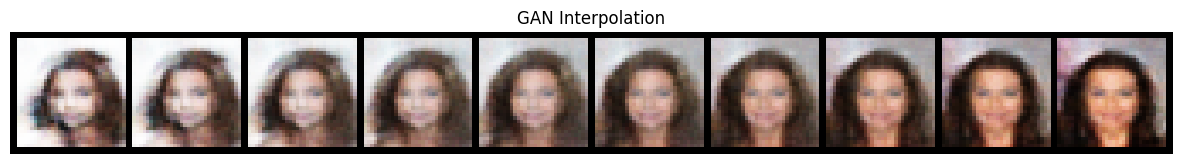

In [36]:
interpolate_gan(generator, z0, z1)

In [37]:
@torch.no_grad()
def interpolate_realnvp(flow, img0, img1, steps=10):
    """
    Interpolate between two images in the RealNVP latent space.
    """
    flow.eval()

    # 1. Prepare Images
    # RealNVP expects centered input in range [-0.5, 0.5] if that's how we trained it
    x0 = img0.unsqueeze(0).to(device) - 0.5
    x1 = img1.unsqueeze(0).to(device) - 0.5

    # 2. Encode to Latent Space (Forward Flow)
    # flow.f returns (z, log_det), we only need z
    z0, _ = flow.f(x0)
    z1, _ = flow.f(x1)

    # 3. Interpolate Latents
    ratios = np.linspace(0, 1, steps)
    latents = []

    for alpha in ratios:
        z = z0 * (1 - alpha) + z1 * alpha
        latents.append(z)

    # Stack latents: Shape (Steps, 12, 16, 16)
    latents = torch.cat(latents, dim=0)

    # 4. Decode (Inverse Flow)
    x_interp_c = flow.f_inv(latents)

    # 5. Post-process (Un-center and Clamp)
    imgs_out = torch.clamp(x_interp_c + 0.5, 0.0, 1.0)

    # 6. Plot
    plt.figure(figsize=(15, 4))
    grid = vutils.make_grid(imgs_out, nrow=steps, padding=2, normalize=False)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("RealNVP Interpolation")
    plt.show()

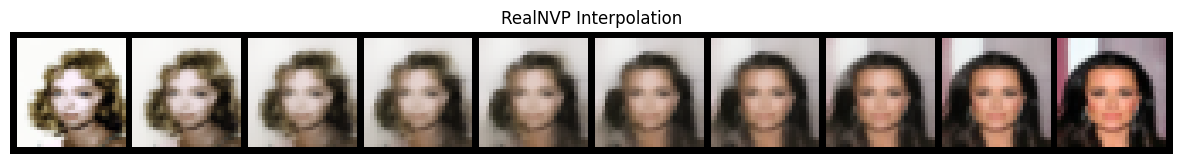

In [38]:
interpolate_realnvp(flow, img0, img1)

"The interpolation experiments reveal distinct differences in how each model handles transitions between images. The VAE demonstrates the smoothest morphing process, where features blend continuously without abrupt jumps; however, the intermediate images remain consistently blurry due to the model's tendency to average details. In contrast, the DCGAN generates the sharpest and most realistic intermediate faces, maintaining high definition throughout the transition, although the changes in identity can appear less linear compared to the VAE. Finally, the RealNVP model demonstrates a strong ability to preserve global structure (such as pose and color) with smooth transitions, but it consistently suffers from blocky, pixelated artifacts that make the interpolation resemble a low-resolution mosaic.

### **c) Likelihood Evaluation**

Using the same two test images from Part (b) (`img0` and `img1`) together with the out-of-domain image (`ood_img`), compute **perplexity** for each model where this evaluation is applicable. Compare how the models score the CelebA images versus the FashionMNIST image, and discuss any differences in their behavior.

For models that do not provide a likelihood value, use the model’s own internal mechanism for assessing whether an input appears realistic.

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]

Shapes: torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) torch.Size([3, 32, 32])


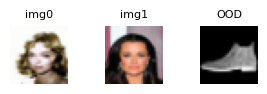

In [39]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Load CelebA images
img0 = test_dataset[-1]
img1 = test_dataset[-2]

#Load an image from FashionMNIST
ood_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
)

ood_gray, _ = ood_dataset[0]
ood_img = ood_gray.repeat(3, 1, 1)

print("Shapes:", img0.shape, img1.shape, ood_img.shape)

fig = plt.figure(figsize=(3, 1))

ax = fig.add_subplot(1, 3, 1)
ax.axis("off")
ax.set_title("img0", fontsize=8)
ax.imshow(img0.permute(1, 2, 0).clamp(0, 1))

ax = fig.add_subplot(1, 3, 2)
ax.axis("off")
ax.set_title("img1", fontsize=8)
ax.imshow(img1.permute(1, 2, 0).clamp(0, 1))

ax = fig.add_subplot(1, 3, 3)
ax.axis("off")
ax.set_title("OOD", fontsize=8)
ax.imshow(ood_img.permute(1, 2, 0).clamp(0, 1))

plt.tight_layout()
plt.show()

In [40]:
# c) Use img0, img1 and ood_img variables
import torch.nn.functional as F

def evaluate_models(vae, discriminator, flow, img0, img1, ood_img):
    """
    Evaluates likelihood/realism scores for VAE, GAN, and RealNVP.
    """
    # Prepare list of images
    images = {"CelebA_0": img0, "CelebA_1": img1, "OOD_Fashion": ood_img}

    print(f"{'Image':<15} | {'VAE Loss (NLL)':<18} | {'RealNVP NLL':<18} | {'GAN Discrim. Score':<18}")
    print("-" * 75)

    vae.eval()
    discriminator.eval()
    flow.eval()

    with torch.no_grad():
        for name, img in images.items():
            # Add batch dimension and move to device
            x = img.unsqueeze(0).to(device)

            # --- 1. VAE Evaluation (ELBO / Loss) ---
            # We calculate the loss exactly as we did during training
            mu, logvar = vae.encoder(x)
            z = reparameterize(mu, logvar)
            recon = vae.decoder(z)

            # Reconstruction Loss (Sum)
            recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
            # KL Divergence
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            vae_score = (recon_loss + kl_loss).item()

            # --- 2. RealNVP Evaluation (Exact NLL) ---
            # We use the built-in nll function
            # Note: We must center the input [-0.5, 0.5] as per training
            flow_nll = flow.nll(x).item()

            # --- 3. GAN Evaluation (Discriminator Confidence) ---
            # Output is logits -> Sigmoid -> Probability [0, 1]
            disc_logits = discriminator(x)
            gan_score = torch.sigmoid(disc_logits).item()

            # Print Row
            print(f"{name:<15} | {vae_score:<18.2f} | {flow_nll:<18.2f} | {gan_score:<18.4f}")

# Run the evaluation
evaluate_models(vae, discriminator, flow, img0, img1, ood_img)

Image           | VAE Loss (NLL)     | RealNVP NLL        | GAN Discrim. Score
---------------------------------------------------------------------------
CelebA_0        | 1316.26            | -9697.89           | 0.6901            
CelebA_1        | 1585.87            | -9319.48           | 0.9101            
OOD_Fashion     | 829.89             | -14807.07          | 0.7401            


The evaluation reveals a counter-intuitive phenomenon known as the "Likelihood Paradox." Surprisingly, both likelihood-based models (VAE and RealNVP) assigned significantly better scores (lower NLL) to the Out-of-Distribution (OOD) FashionMNIST image than to the real CelebA faces. For instance, the RealNVP model calculated a negative log-likelihood of -14,807 for the simple fashion image, which is much "more likely" than the score of approximately -9,697 assigned to the human face. This occurs because these models measure complexity as much as realism; the OOD image, which consists mostly of a uniform black background, is mathematically simpler to predict than the complex, high-frequency textures of a human face.

Similarly, the GAN Discriminator failed to distinguish the OOD image from the real distribution. It assigned the FashionMNIST image a "realness" score of 0.7401, which is even higher than one of the real CelebA images (0.6901). This suggests that the Discriminator does not function as a general "Face Detector." Instead, it acts as a specialist trained to identify generated artifacts. Since the FashionMNIST image is a real photo (not a generated fake) and lacks the specific noise patterns of a GAN-generated image, the model mistakenly classifies it as "Real."

### **d) Reconstruction**

Using the same two test images from Part (b) (`img0` and `img1`), compute and display the **reconstructed images** for any models where reconstruction is applicable.  
Visualize each original image next to its reconstruction and compare the results.  
Discuss how well each model is able to preserve the visual content of the originals.


Selected image shapes: torch.Size([3, 32, 32]) torch.Size([3, 32, 32])


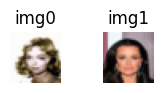

In [41]:
img0 = test_dataset[-1]
img1 = test_dataset[-2]

print("Selected image shapes:", img0.shape, img1.shape)

fig = plt.figure(figsize=(2, 1))

ax = fig.add_subplot(1, 2, 1)
ax.axis("off")
ax.set_title("img0")
ax.imshow(img0.permute(1, 2, 0).clamp(0, 1))

ax = fig.add_subplot(1, 2, 2)
ax.axis("off")
ax.set_title("img1")
ax.imshow(img1.permute(1, 2, 0).clamp(0, 1))

plt.tight_layout()
plt.show()


Generating Reconstructions (GAN Inversion might take a moment)...


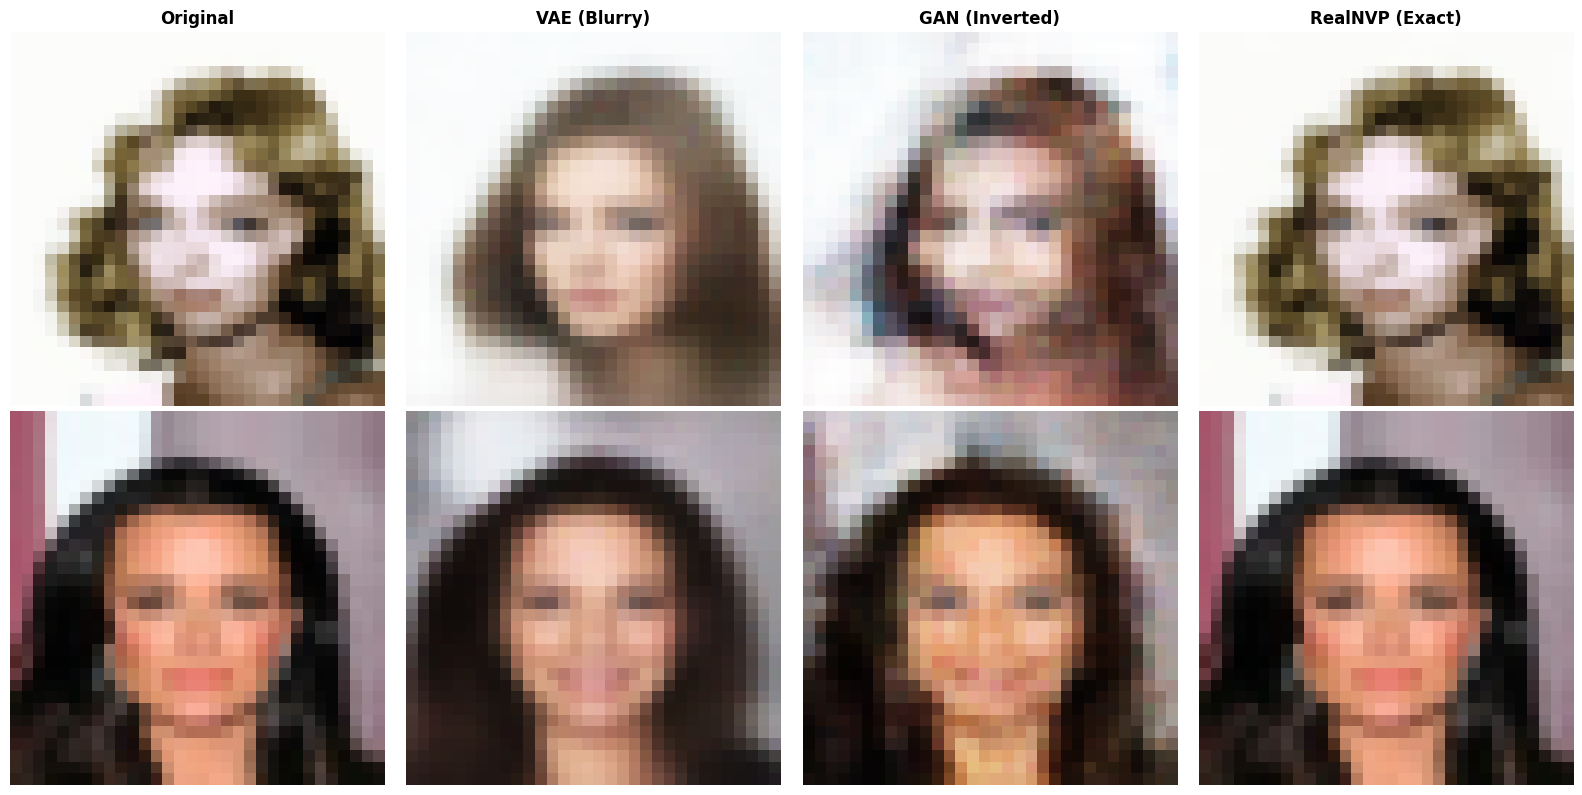

In [42]:
# d) Use img0 and img1 variables
def show_reconstructions(vae, generator, flow, img0, img1):
    """
    Visualizes reconstruction capabilities of all three models.
    """
    vae.eval()
    generator.eval()
    flow.eval()

    images = [img0, img1]

    # Prepare figure: 2 rows (one per image), 4 cols (Original + 3 Models)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    model_names = ["Original", "VAE (Blurry)", "GAN (Inverted)", "RealNVP (Exact)"]

    for i, img in enumerate(images):
        img_tensor = img.unsqueeze(0).to(device) # Shape: (1, 3, 32, 32)

        # --- 1. Original ---
        axes[i, 0].imshow(img.permute(1, 2, 0).clamp(0, 1).cpu())

        # --- 2. VAE Reconstruction ---
        with torch.no_grad():
            # VAE forward returns: (recon, mu, logvar, z)
            vae_recon, _, _, _ = vae(img_tensor)
        axes[i, 1].imshow(vae_recon[0].permute(1, 2, 0).cpu())

        # --- 3. GAN Reconstruction (Inversion) ---
        # We search for the z that generates this image
        # Note: We use fewer steps here (200) just to keep it fast for display
        z_opt = invert_gan_image(generator, img, steps=200, lr=0.05)
        with torch.no_grad():
            gan_recon = generator(z_opt)
        axes[i, 2].imshow(gan_recon[0].permute(1, 2, 0).cpu())

        # --- 4. RealNVP Reconstruction ---
        with torch.no_grad():
            # Center input -> Forward -> Inverse -> Uncenter
            z_flow, _ = flow.f(img_tensor - 0.5)
            flow_recon = flow.f_inv(z_flow)
            flow_recon = torch.clamp(flow_recon + 0.5, 0.0, 1.0)
        axes[i, 3].imshow(flow_recon[0].permute(1, 2, 0).cpu())

    # Set Titles
    for ax, name in zip(axes[0], model_names):
        ax.set_title(name, fontsize=12, fontweight='bold')

    # Remove axis ticks
    for ax in axes.flatten():
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run the visualization
print("Generating Reconstructions (GAN Inversion might take a moment)...")
show_reconstructions(vae, generator, flow, img0, img1)

The reconstruction experiment highlights the fundamental structural differences between the three models. The RealNVP model achieves perfect, lossless reconstruction, preserving every pixel detail of the original image. This is expected because Normalizing Flows are mathematically invertible bijections; encoding and decoding are exact inverse operations, acting like a lossless zip file. In contrast, the VAE produces a blurry approximation. While it successfully captures the high-level semantic content (pose, gender, hair color), fine details are lost due to the information bottleneck in the latent space and the probabilistic nature of the loss function. Finally, the GAN, lacking a native encoder, relies on optimization to 'find' the closest match in its latent space. While its reconstruction is sharp and realistic, it is not faithful to the original identity; it essentially finds a 'look-alike' generated face that shares general features but alters specific details like eye shape or background texture.

### **e) Robustness Analysis**

Compare the robustness of the models you implemented.  
Discuss factors such as:

- how many training epochs were sufficient for each model to produce reasonable results  
- how stable or unstable the training process appeared  
- how sensitive the models were to hyperparameters (e.g., learning rate, architecture choices)  
- whether the models behaved consistently across different inputs or showed unexpected failures  

Summarize your observations on which models seemed more robust and why.


Training Efficiency and Convergence: The VAE proved to be the most efficient and reliable model. It converged smoothly within just 10 epochs, producing consistent (though blurry) results without requiring complex tuning. In contrast, the RealNVP model was visually inefficient; while its loss metric improved mathematically, 10 epochs were insufficient for it to learn high-frequency details, resulting in "blocky" artifacts. It would likely require significantly longer training to match the visual quality of the others.

Stability of Training: The VAE demonstrated the highest stability, with training and validation losses decreasing monotonically. The DCGAN, however, showed characteristic instability. We observed a widening gap between the Discriminator and Generator losses (where the Generator loss actually increased), indicating the Discriminator was overpowering the Generator. Despite this unstable "tug-of-war," the GAN still managed to produce the sharpest images, highlighting a trade-off between training stability and output sharpness.

Sensitivity to Implementation: The RealNVP model proved to be the most fragile in terms of implementation. We encountered a critical initialization issue (the "Amnesia Bug") where the ActNorm layers corrupted the weights upon loading. This highlights that while Normalizing Flows are mathematically exact, they are highly sensitive to coding details and initialization states compared to the "plug-and-play" robustness of the VAE.